<h1>PyTorch Tutorial: A step-by-step walkthrough of building a neural network from scratch</h1>

Source: https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

PyTorch is one of the most popular libraries for deep learning. It provides a much more direct debugging experience than TensorFlow. It has several other perks such as distributed training, a robust ecosystem, cloud support, allowing you to write production-ready code, etc. 

In this notebook, we will build a simple artificial neural network model using the PyTorch library. 

In [19]:
# !pip install torch -q

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

from torch import nn
from torch import optim

import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


<h2>Data definition & preparation</h2> 

The dataset we will be using in our tutorial is make_circles from scikit-learn - see the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html" target="_blank" rel="noopener">documentation</a>. It’s a toy dataset containing a large circle with a smaller circle in a two-dimensional plane and two features. For our demonstration, we used 10,000 samples and added a 0.05 standard deviation of Gaussian noise to the data. 

Before we build our neural network, it’s good practice to split our data into training and testing sets so we can evaluate the model's performance on unseen data.

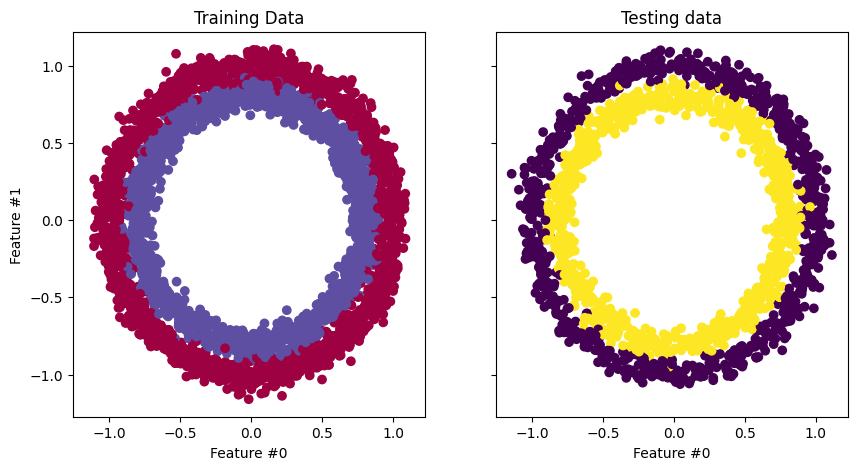

In [9]:
# Creat e a dataset with 10,000 samples.
X, y = make_circles(n_samples = 5000,
                    noise= 0.05,
                    random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

The next step is to convert the training and testing data from <a href="https://numpy.org/doc/stable/reference/generated/numpy.array.html" target="_blank" rel="noopener">NumPy arrays</a> to <a href="https://pytorch.org/docs/stable/tensors.html" target="_blank" rel="noopener">PyTorch tensors</a>. To do this we are going to create a custom dataset for our training and test files. We are also going to leverage PyTorch’s <a href="https://pytorch.org/docs/stable/data.html" target="_blank" rel="noopener">Dataloader</a> module so we can train our data in batches. Here’s the code:&nbsp;

In [13]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


#
# Batch: 1
# X shape: torch.Size([64, 2])
# y shape: torch.Size([64])
#

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


Now let’s move on to implementing and training our neural network. 
<h2>Neural network implementation & model training</h2>

We are going to implement a simple two-layer neural network that uses the ReLU activation function (torch.nn.functional.relu). To do this we are going to create a class called NeuralNetwork that inherits from the nn.Module which is the base class for all neural network modules built in PyTorch. 

Here’s the code: 

In [14]:
input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)


#
# NeuralNetwork(
#   (layer_1): Linear(in_features=2, out_features=10, bias=True)
#   (layer_2): Linear(in_features=10, out_features=1, bias=True)
# )
#

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


<h2>And that’s all&nbsp;</h2>
To train the model we must define a loss function to use to calculate the gradients and an optimizer to update the parameters. For our demonstration, we are going to use <a href="https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html" target="_blank" rel="noopener">binary crossentropy</a> and <a href="https://pytorch.org/docs/stable/generated/torch.optim.SGD.html" target="_blank" rel="noopener">stochastic gradient descent</a> with a learning rate of 0.1.&nbsp;

In [15]:
learning_rate = 0.1

loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Let’s train our model

In [16]:
num_epochs = 200
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

# 
# Training Complete
# 

Training Complete


Since we tracked the loss values, we can visualize the loss of the model over time. 

ValueError: x and y must have same first dimension, but have shapes (10500,) and (10600,)

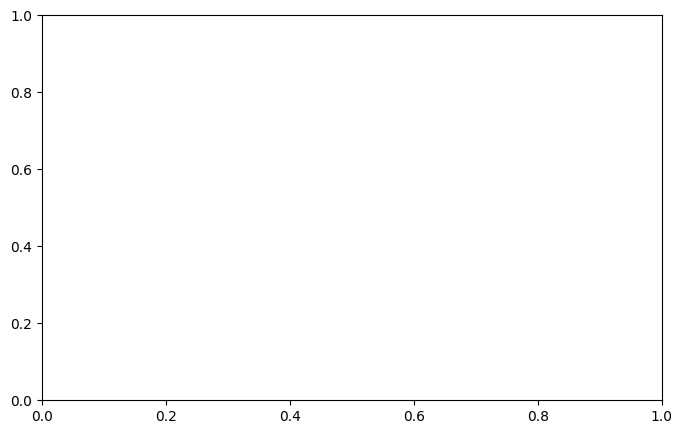

In [17]:
step = np.linspace(0, 100, 10500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

The image above should look like this:
<img width="80%" height="80%" src='pic/step-wise_loss.png'/>

The visualization above shows the loss of our model over 100 epochs. Initially, the loss starts at 0.7 and gradually decreases - this informs us that our model has been improving its predictions over time. However, the model seems to plateau around the 60 epoch mark, which may be down to a variety of reasons, such as the model may be in the region of a local or global minimum of the loss function. 

Nonetheless, the model has been trained and is ready to make predictions on new instances - let’s look at how to do that in the next section.
<h2>Predictions & model evaluation</h2>

Making predictions with our PyTorch neural network is quite simple. 

In [48]:
# 
# We're not training so we don't need to calculate the gradients for our outputs
# 

y_pred = []
y_test = []
total = 0
correct = 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

# 
# Accuracy of the network on the 3300 test instances: 97%
# 

Accuracy of the network on the 3300 test instances: 97%


<strong>Note:</strong> Each run of the code would produce a different output so you may not get the same results. 

The code above loops through the test batches, which are stored in the test_dataloader variable, without calculating the gradients. We then predict the instances in the batch and store the results in a variable called outputs. Next, we determine set all the values less than 0.5 to 0 and those equal to or greater than 0.5 to 1. These values are then appended to a list for our predictions.

After that, we add the actual predictions of the instances in the batch to a variable named total. Then we calculate the number of correct predictions by identifying the number of predictions equal to the actual classes and totaling them. The total number of correct predictions for each batch is incremented and stored in our correct variable.

To calculate the accuracy of the overall model, we multiply the number of correct predictions by 100 (to get a percentage) and then divide it by the number of instances in our test set. Our model had 97% accuracy. We dig in further using the confusion matrix and scikit-learn’s classification_report to get a better understanding of how our model performed.



In [49]:
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


print(classification_report(y_test, y_pred))

# 
#               precision    recall  f1-score   support

#          0.0       0.98      0.97      0.98      1635
#          1.0       0.98      0.98      0.98      1665

#     accuracy                           0.98      3300
#    macro avg       0.98      0.98      0.98      3300
# weighted avg       0.98      0.98      0.98      3300
#

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1635
         1.0       0.97      0.99      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



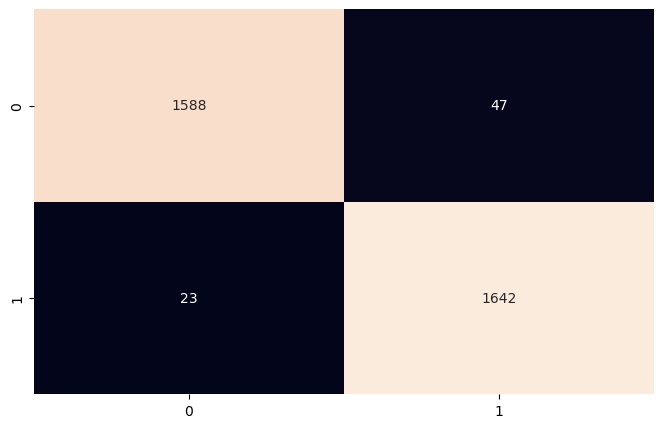

In [50]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))


sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()

The heatmap should look like this:
<img width="80%" height="80%" src='pic/heatmap.png'/>

Our model is performing pretty well. I encourage you to explore the code and make some changes to help make what we’ve covered in this article stick.  

In this PyTorch tutorial, we covered the foundational basics of neural networks and used PyTorch, a Python library for deep learning, to implement our network. We used the circle's dataset from scikit-learn to train a two-layer neural network for classification. We then made predictions on the data and evaluated our results using the accuracy metric. 